In [3]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
def BinaryCIFAR10create_imbalanced_datasets(
        root='data',
        download=True,
        batch_size=64,
        random_seed = 42,
        fractions=[0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    cifar_transform = transforms.ToTensor()
    Full_train_dataset = datasets.CIFAR10(root=root, train=True, transform=cifar_transform, download=download)
    
    train_data = torch.tensor(Full_train_dataset.data, dtype=torch.float)
    train_labels = torch.tensor(Full_train_dataset.targets, dtype=torch.long)
    
     # Permute the training data to be [N, C, H, W] => [N, 3, 32, 32]
    train_data = train_data.permute(0, 3, 1, 2)


    train_index_label3 = (train_labels == 3) # 3 is cat
    train_index_label4 = (train_labels == 4) # 4 is deer

    train_data_label3 = train_data[train_index_label3]
    train_data_label4 = train_data[train_index_label4]
    train_labels_label3 = train_labels[train_index_label3]
    train_labels_label4 = train_labels[train_index_label4]

    num_label4 = len(train_data_label4)
    num_label3 = len(train_data_label3)
    print('Number of images with label 3:', num_label3)
    print('Number of images with label 4:', num_label4)

    train_datasets_dict = {}
    for fraction in fractions:
        num_label3_need = int(num_label4 * fraction)
        # Randomly choose a subset of label-3 images
        chosen_indices_label3 = np.random.choice(len(train_data_label3), num_label3_need, replace=False)
        subset_label3_data = train_data_label3[chosen_indices_label3]
        subset_label3_labels = train_labels_label3[chosen_indices_label3]

        # Concatenate label-4 data with the chosen subset of label-3 data
        new_train_data = torch.cat((train_data_label4, subset_label3_data), dim=0)
        new_train_labels = torch.cat((train_labels_label4, subset_label3_labels), dim=0)

        # Create a new training dataset
        new_train_dataset = TensorDataset(new_train_data, new_train_labels)
        train_dataloader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
        train_datasets_dict[f'train_{fraction}'] = train_dataloader


    test_dataset = datasets.CIFAR10(root=root, train=False, transform=cifar_transform, download=download)
    test_data_raw = torch.tensor(test_dataset.data, dtype=torch.float)
    test_labels_raw = torch.tensor(test_dataset.targets, dtype=torch.long)

    test_data_raw = test_data_raw.permute(0, 3, 1, 2)

    test_index_label34 = (test_labels_raw == 3) | (test_labels_raw == 4)
    test_data = test_data_raw[test_index_label34]
    test_labels = test_labels_raw[test_index_label34]
    test_dataset = TensorDataset(test_data, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    data_loaders_dict = {**train_datasets_dict, **{'test': test_dataloader}}
    return data_loaders_dict

In [5]:
if __name__ == '__main__':
    BinaryCIFAR10DataLoader = BinaryCIFAR10create_imbalanced_datasets(
        root = '/Users/max/MasterThesisData/CIFAR10',
        download=True,
        batch_size=64,
        random_seed = 42,
        fractions=[0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
    )
    CIFAR10_train_loader0005 = BinaryCIFAR10DataLoader['train_0.005']
    CIFAR10_train_loader001 = BinaryCIFAR10DataLoader['train_0.01']
    CIFAR10_train_loader002 = BinaryCIFAR10DataLoader['train_0.02']
    CIFAR10_train_loader005 = BinaryCIFAR10DataLoader['train_0.05']
    CIFAR10_train_loader010 = BinaryCIFAR10DataLoader['train_0.1']
    CIFAR10_train_loader020 = BinaryCIFAR10DataLoader['train_0.2']
    CIFAR10_test_loader = BinaryCIFAR10DataLoader['test']

    print('Number of batches in train_loader_0.005:', len(CIFAR10_train_loader0005))
    print('Number of batches in train_loader_0.01:', len(CIFAR10_train_loader001))
    print('Number of batches in train_loader_0.02:', len(CIFAR10_train_loader002))
    print('Number of batches in train_loader_0.05:', len(CIFAR10_train_loader005))
    print('Number of batches in train_loader_0.1:', len(CIFAR10_train_loader010))
    print('Number of batches in train_loader_0.2:', len(CIFAR10_train_loader020))
    print('Number of batches in test_loader:', len(CIFAR10_test_loader))
    
    print('Number of images in train_loader_0.005:', len(CIFAR10_train_loader0005.dataset))
    print('Number of images in train_loader_0.01:', len(CIFAR10_train_loader001.dataset))
    print('Number of images in train_loader_0.02:', len(CIFAR10_train_loader002.dataset))
    print('Number of images in train_loader_0.05:', len(CIFAR10_train_loader005.dataset))
    print('Number of images in train_loader_0.1:', len(CIFAR10_train_loader010.dataset))
    print('Number of images in train_loader_0.2:', len(CIFAR10_train_loader020.dataset))
    print('Number of images in test_loader:', len(CIFAR10_test_loader.dataset))

Number of images with label 3: 5000
Number of images with label 4: 5000
Number of batches in train_loader_0.005: 79
Number of batches in train_loader_0.01: 79
Number of batches in train_loader_0.02: 80
Number of batches in train_loader_0.05: 83
Number of batches in train_loader_0.1: 86
Number of batches in train_loader_0.2: 94
Number of batches in test_loader: 32
Number of images in train_loader_0.005: 5025
Number of images in train_loader_0.01: 5050
Number of images in train_loader_0.02: 5100
Number of images in train_loader_0.05: 5250
Number of images in train_loader_0.1: 5500
Number of images in train_loader_0.2: 6000
Number of images in test_loader: 2000


In [6]:
# save the data loaders to pkl
import pickle

Binary_CIFAR10_DataLoader = {
    "train_loader_0.005": CIFAR10_train_loader0005,
    "train_loader_0.01": CIFAR10_train_loader001,
    "train_loader_0.02": CIFAR10_train_loader002,
    "train_loader_0.05": CIFAR10_train_loader005,
    "train_loader_0.10": CIFAR10_train_loader010,
    "train_loader_0.20": CIFAR10_train_loader020,
    "test_loader": CIFAR10_test_loader,
}

with open('Binary_CIFAR10_DataLoader.pkl', 'wb') as f:
    pickle.dump(Binary_CIFAR10_DataLoader, f)
    print('Binary_CIFAR10_DataLoader saved to Binary_CIFAR10_DataLoader.pkl')

Binary_CIFAR10_DataLoader saved to Binary_CIFAR10_DataLoader.pkl


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def Multi_get_class_distirbution(data_loader):
    class_distribution = {}
    for i, (data, target) in enumerate(data_loader):
        for label in target:
            label = label.item()
            if label in class_distribution:
                class_distribution[label] += 1
            else:
                class_distribution[label] = 1
    return class_distribution

In [8]:
class_distribution_train0005 = Multi_get_class_distirbution(CIFAR10_train_loader0005)
class_distribution_train001 = Multi_get_class_distirbution(CIFAR10_train_loader001)
class_distribution_train002 = Multi_get_class_distirbution(CIFAR10_train_loader002)
class_distribution_train005 = Multi_get_class_distirbution(CIFAR10_train_loader005)
class_distribution_train010 = Multi_get_class_distirbution(CIFAR10_train_loader010)
class_distribution_train020 = Multi_get_class_distirbution(CIFAR10_train_loader020)
class_distribution_test = Multi_get_class_distirbution(CIFAR10_test_loader)


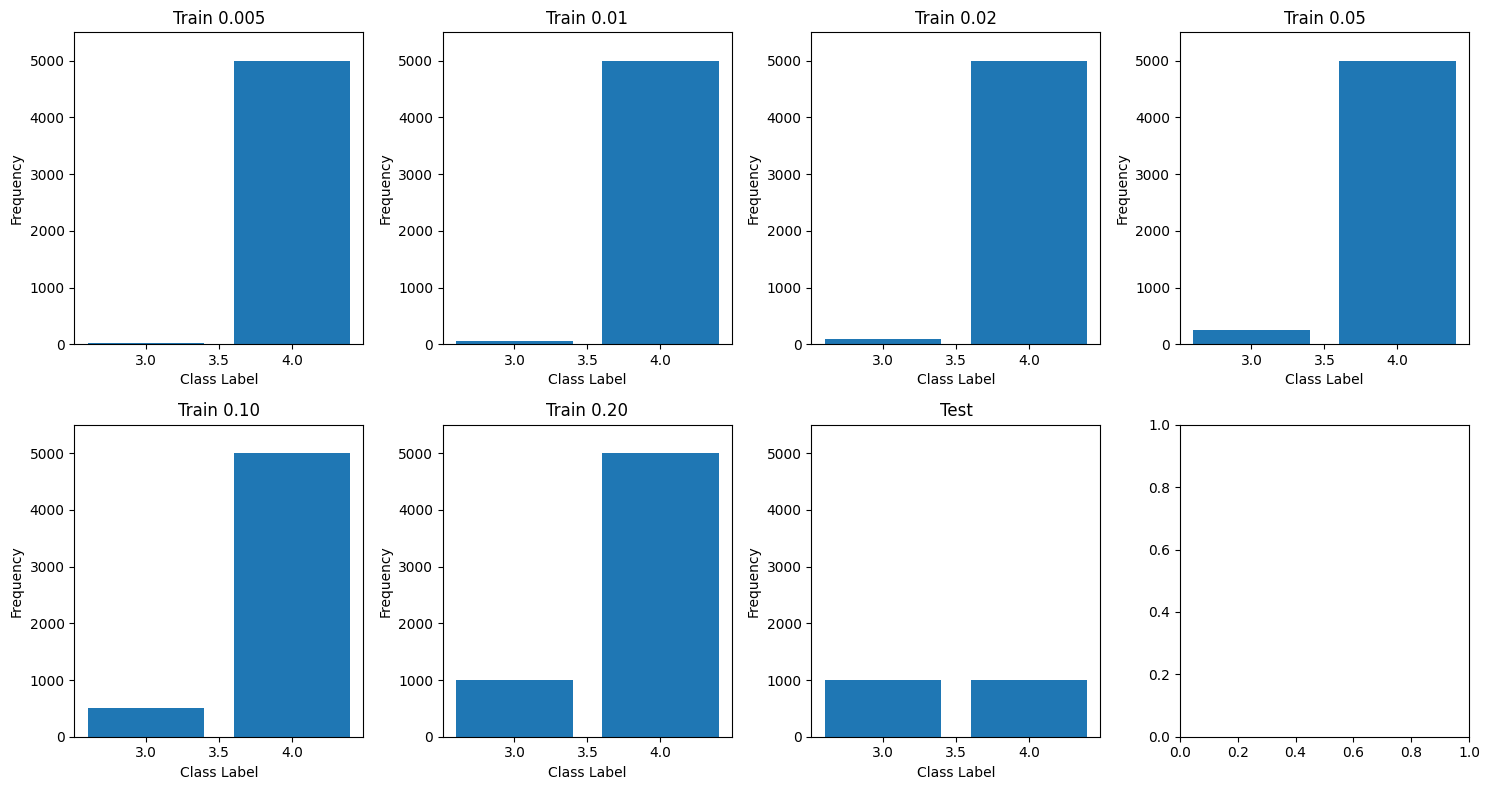

In [9]:
import matplotlib.pyplot as plt


dists = [
    (class_distribution_train0005, 'Train 0.005'),
    (class_distribution_train001, 'Train 0.01'),
    (class_distribution_train002, 'Train 0.02'),
    (class_distribution_train005, 'Train 0.05'),
    (class_distribution_train010, 'Train 0.10'),
    (class_distribution_train020, 'Train 0.20'),
    (class_distribution_test,    'Test')
]


fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()  


max_count = max([max(dist_dict.values()) for dist_dict, _ in dists])

for ax, (dist_dict, title) in zip(axes, dists):
    
    ax.bar(dist_dict.keys(), dist_dict.values())
    ax.set_title(title)
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Frequency')
    
    ax.set_ylim([0, max_count * 1.1]) 

plt.tight_layout()
plt.show()